In [34]:
#!apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/3bf863cc.pub
#!apt-get update && apt install -y git


In [35]:
#!pip install git+https://github.com/matterport/Mask_RCNN.git --upgrade
!pip install git+https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git --upgrade

  Cloning https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git to /tmp/pip-req-build-07og04zj
  Running command git clone --filter=blob:none --quiet https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git /tmp/pip-req-build-07og04zj
  Resolved https://github.com/mdrokz/Mask-RCNN-TF2.7.0-keras2.7.0.git to commit 87246652e054b79781a155ab151ecad0b1634e48
  Preparing metadata (setup.py) ... done


# Dependencies

In [36]:
!pip install numpy scipy Pillow cython matplotlib imgaug opencv-python datasets IPython[all]
#!pip install scikit-image==0.16.2 keras==2.0.8 h5py==2.10.0
#!pip install tensorflow-gpu==1.15.5'

!pip install scikit-image==0.16.2
!pip install tensorflow==2.7.0
!pip install keras==2.7.0
!pip install opencv-python
!pip install h5py==2.10.0


In [37]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"]  = "python"

# Import
In order to train, we would need GPU power

In [38]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)
import pathlib
from numpy import asarray
import mrcnn.utils
import mrcnn.config
import mrcnn.model
from mrcnn import visualize
from datasets import load_dataset
import numpy as np
from mrcnn import utils
import imgaug
import warnings

2.7.0
2.7.0


In [39]:
WEIGHTS_PATH = pathlib.Path("weights")
WEIGHTS_PATH.mkdir(exist_ok=True)

WEIGHTS_CHECKPOINT_PATH = WEIGHTS_PATH.joinpath("checkpoints")
WEIGHTS_CHECKPOINT_PATH.mkdir(exist_ok=True)


COCO_WEIGHTS = WEIGHTS_PATH.joinpath("mask_rcnn_coco.h5")
FROG_WEIGHTS = WEIGHTS_PATH.joinpath('mask_rcnn_frog.h5')


CLASS_NAME = "frog_stomach"
CLASS_NAMES = [CLASS_NAME, "BG"]
FROG_IMAGES = "./frog_photos"
FROG_DATASET = "./pelophylax_lessonae" ""#"perara/pelophylax_lessonae"


WEIGHTS_CHECKPOINT_PATH.joinpath(CLASS_NAME).mkdir(exist_ok=True)

# Download COCO weights if missing

In [40]:
if not COCO_WEIGHTS.exists():
    utils.download_trained_weights(str(COCO_WEIGHTS.absolute()))

# Configure dataset

In [41]:

from mrcnn.model import DataGenerator
from PIL import Image, ImageDraw


class FrogStomachDataset(mrcnn.utils.Dataset):

    def load_dataset(self, images_dir: str, dataset_dir: str=None, is_train=True):
        # Adds information (image ID, image path, and annotation file path) about each image in a dictionary.
        self.add_class("dataset", 1, CLASS_NAME)

        images_dir_path = pathlib.Path(images_dir)
        dataset_split = "train" if is_train else "validation"
        ds = load_dataset(
            FROG_DATASET,
            name="default",
            splits=[dataset_split],
            image_dir=images_dir_path,
            dataset_dir=dataset_dir
        )

        for sample in ds[dataset_split]:
            image_id = sample["image_id"]
            image_path = sample["image_path"]
            annotation = sample["segmentation"]
            width = sample["width"]
            height = sample["height"]
            category_id = sample["category_id"]

            self.add_image('dataset', image_id=image_id, path=image_path, annotation=annotation, width=width, height=height, category_id=category_id)

    # Loads the binary masks for an image.
    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        annotations = image_info['annotation']
        width = image_info["width"]
        height = image_info["height"]
        category_id = image_info["category_id"]
        instance_masks = []
        class_ids = []


        mask = Image.new('1', (width, height))
        mask_draw = ImageDraw.ImageDraw(mask, '1')
        for segmentation in annotations:
            try:
                mask_draw.polygon(segmentation, fill=1)
            except:
                pass
            bool_array = np.array(mask) > 0
            instance_masks.append(bool_array)
            class_ids.append(category_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask.astype("bool"), asarray(class_ids, dtype='int32')

# Load Training and Validation Dataset

In [42]:
# Train
train_dataset = FrogStomachDataset()
train_dataset.load_dataset(
    images_dir=str(FROG_IMAGES),
    dataset_dir=str(FROG_DATASET),
    is_train=True
)
train_dataset.prepare()

val_dataset = FrogStomachDataset()
val_dataset.load_dataset(
    images_dir=str(FROG_IMAGES),
    dataset_dir=str(FROG_DATASET),
    is_train=False
)
val_dataset.prepare()

Using custom data configuration default-4f709f9fcb90a78e
Found cached dataset pelophylax_lessonae (/home/per/.cache/huggingface/datasets/pelophylax_lessonae/default-4f709f9fcb90a78e/0.0.0/e3d448178a59568d51f6b4f5bff85105604bdf9469c96fd6494e7c2d76c25e3c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9708ba264ff4d9b3
Found cached dataset pelophylax_lessonae (/home/per/.cache/huggingface/datasets/pelophylax_lessonae/default-9708ba264ff4d9b3/0.0.0/e3d448178a59568d51f6b4f5bff85105604bdf9469c96fd6494e7c2d76c25e3c)


  0%|          | 0/1 [00:00<?, ?it/s]

# Visualize samples from Validation Set

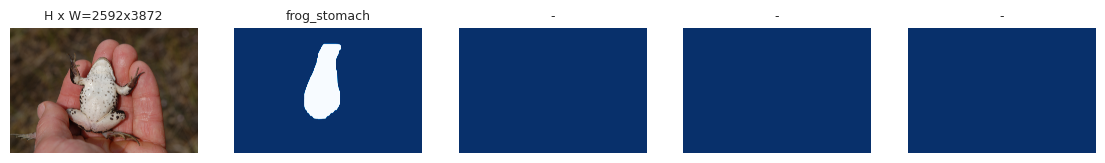

In [43]:
image_ids = np.random.choice(val_dataset.image_ids, 1)
for image_id in image_ids:
    image = val_dataset.load_image(image_id)
    mask, class_ids = val_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, val_dataset.class_names)

# Setup Mask R-CNN - Training Model

In [50]:
class FrogStomachConfig(mrcnn.config.Config):
    NAME = CLASS_NAME
    GPU_COUNT = 1
    NUM_CLASSES =  1 + 1


    DETECTION_MIN_CONFIDENCE = 0.9

    IMAGES_PER_GPU = 64
    STEPS_PER_EPOCH = 1000
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

# Model Configuration
frog_config = FrogStomachConfig()

# Build the Mask R-CNN Model Architecture
train_model = mrcnn.model.MaskRCNN(mode='training',
                             model_dir=str(WEIGHTS_PATH.absolute()),
                             config=frog_config)

"""train_model.keras_model.add_metric(
    tf.keras.metrics.MeanIoU(name="mean_io_u_1",dtype=tf.float32,num_classes=2), name="metric_io_u"
)"""
train_model.load_weights(filepath=str(COCO_WEIGHTS.absolute()),
                         by_name=True,
                         exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Setup Mask R-CNN - Inference Model

In [51]:
class InferenceConfig(FrogStomachConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
inference_model = mrcnn.model.MaskRCNN(mode="inference",
                             config=inference_config,
                             model_dir=str(WEIGHTS_PATH.absolute()))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Train using Transfer Learning

In [ ]:
from frog_identity_recognition.callbacks import MeanAveragePrecisionCallback

"""mean_average_precision_callback = MeanAveragePrecisionCallback(
    train_model,
    inference_model,
    val_dataset,
    calculate_map_at_every_X_epoch=1,
    verbose=1
)"""

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_model.train(train_dataset=train_dataset,
                val_dataset=val_dataset,
                learning_rate=frog_config.LEARNING_RATE,
                custom_callbacks=[], # mean_average_precision_callback
                epochs=10,
                layers='heads')
    """augmentation = imgaug.augmenters.Sometimes(0.5, [
        imgaug.augmenters.Fliplr(0.5),
        imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
    ]),"""

    train_model.keras_model.save_weights(str(FROG_WEIGHTS.absolute()))



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/per/Downloads/Auto-Annotate/frog_identity_recognition/weights/frog_stomach20221002T1844/mask_rcnn_frog_stomach_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbo

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
train_model.train(train_dataset, val_dataset,
            learning_rate=frog_config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")


In [ ]:
inference_model_path = inference_model.find_last()

print("Loading weights from ", inference_model_path)
inference_model.load_weights(inference_model_path, by_name=True)

In [ ]:
import random
# Test on a random image
image_id = random.choice(val_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    mrcnn.model.load_image_gt(val_dataset, inference_config, image_id)



visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            train_dataset.class_names, figsize=(8, 8))


In [ ]:
from mrcnn.model import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

dataset = train_dataset
config = inference_config

image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask = mrcnn.model.load_image_gt(dataset, config, image_id)

print(image.shape)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = inference_model.detect([image], verbose=1)

# Display results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:

dataset = train_dataset

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
